In [82]:
from torch import set_grad_enabled, clamp, matmul, Tensor, sum, ones, randn, empty, max, exp
from torch.nn.init import normal_
from random import uniform
from math import pi, sqrt
import matplotlib.pyplot as plt
import random
from numpy import mean

In [2]:
set_grad_enabled(False)

In [3]:
def gen_point():
    center_x, center_y = 0.5, 0.5
    R = 1/sqrt(2*pi)
    
    rand_x, rand_y = uniform(0, 1), uniform(0, 1)
    
    res = 0
    if (rand_x - center_x) ** 2 + (rand_y - center_y) ** 2 <= R ** 2: #inside
        res = 1
        
    return [rand_x, rand_y], res

def gen_points(N):
    ps = []
    results = []
    for _ in range(N):
        p, res = gen_point()
        ps.append(p)
        results.append(res)
    return ps, results



In [4]:
def convert_to_one_hot(y):
    y_onehot = empty(y.size(0), 2) #2 because boolean one hot
    y_onehot.zero_()
    y_onehot[range(y.size(0)), y.long()]=1
    return y_onehot

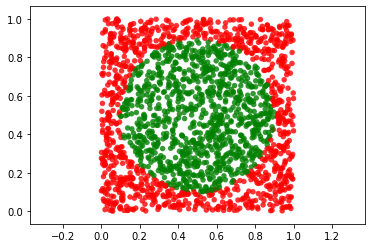

In [5]:
#generate 1k train + 1k test
all_points, all_results = gen_points(2000)

fig, ax = plt.subplots()
plt.axis('equal')


for p,r in zip(all_points, all_results):
    ax.scatter(p[0], p[1], alpha=0.8, c='green' if r else 'red', edgecolors='none', s=30)
    

In [6]:
all_points = Tensor(all_points)
all_results = Tensor(all_results)
all_results_one_hot = convert_to_one_hot(all_results)



train_pts, test_pts = all_points[:1000], all_points[1000:]
train_res, test_res = all_results[:1000], all_results[1000:]
train_res_1h, test_res_1h = all_results_one_hot[:1000], all_results_one_hot[1000:]




In [7]:
mean,std = train_pts.mean(), train_pts.std()
train_pts.sub_(mean).div_(std)
test_pts.sub_(mean).div_(std)

tensor([[-1.2066, -0.8005],
        [-1.0789,  0.8114],
        [-0.5373, -1.2238],
        ...,
        [ 0.4861, -1.6634],
        [ 0.9060, -0.9739],
        [-1.5039,  1.0932]])

In [8]:
class Module (object):
    def __init__(self):
        self.x = None           # the input to the current module
        self.prev_grad = None   # gradient at the output of this module
    
    def forward (self ,x):
        raise NotImplementedError
    def backward (self , prev_grad):
        raise NotImplementedError
    def step(self, lr):
        raise NotImplementedError

In [9]:
class ReLU(Module):
    
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        self.x = x
        return x.clamp(min = 0)       #negative values -> 0, positive values stay the same. relu = max(0,x)
    
    def backward(self, prev_grad):
        self.prev_grad = prev_grad    #cache the gradient at the output 
        curr_grad = prev_grad.clone() #copy it for returning the new gradient
        curr_grad[self.x < 0] = 0     #relu = max(0,x), grad_relu = 0 if x <= 0 else 1.
        return curr_grad

    
    def step(self, lr):
        pass
    

In [10]:
class Sigmoid(Module):
    
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        self.x = x
        return 1 / (1 + exp(-x))
    
    def backward(self, prev_grad):
        self.prev_grad = prev_grad
        curr_grad = prev_grad.clone()
        gv = 1 / (1 + exp(-self.x))
        curr_grad = prev_grad * gv * (1- gv)
        return curr_grad

    
    def step(self, lr):
        pass
    

In [136]:
class Linear(Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        
        self.w = randn(in_dim, out_dim) * 0.2 # random weights from normal dist. 
        self.b = randn(1, out_dim) * 0.2      # random bias from normal dist.
                                              # scale with 0.2 not to have inf values and losses.
        #print('w', self.w)
        #print('b', self.b)
        
    def forward(self, x):
        self.x = x
        return matmul(x, self.w) + self.b     # without the activation
    
    def backward(self, prev_grad):
        self.prev_grad = prev_grad                      # cache the grad at the output for weight update.         
        current_grad = matmul(prev_grad, self.w.t())    # compute the gradient wrt x
        return current_grad
    
        
    def step(self, lr):
        self.w -= lr * (self.x.t() @ self.prev_grad)   # multiply the grad at output with dy/dw to update the weights.
        self.b -= lr* (self.prev_grad.sum(dim=0))      # dy/db = 1. then dL / db = dy, which is the grad at the output.
    

In [12]:
class Sequential(Module):
    def __init__(self, module_list):
        self.module_list = module_list
        
    def forward(self, x):
        out = self.module_list[0].forward(x)
        for module in self.module_list[1:]:
            out = module.forward(out)
        return out
    
    def backward(self, gradwrtoutput):
        for model in self.module_list[::-1]:
            gradwrtoutput  = model.backward(gradwrtoutput)
            
    def step(self, lr):
        for module in self.module_list:
            module.step(lr)

In [13]:
#return mse loss, grad at output
def mse(pred, true):
    return sum((pred - true)**2),  2* (pred - true)

In [166]:
def train(model, train_pts, train_res_1h, n_epoch, lr):
    model_history = dict()
    
    train_loss = []
    for e in range(n_epoch):
        pred = model.forward(train_pts)
        loss, grad_at_output = mse(pred, train_res_1h.view(-1, 2))
        model.backward(grad_at_output)
        model.step(lr)
        train_loss.append(loss.item())
        
    model_history['train_loss'] = train_loss
    return model_history

In [120]:
def model_selector(mid):
    if mid == 0:
        model = Sequential([Linear(2, 25), ReLU(), Linear(25,25), ReLU(),Linear(25,25), ReLU(), Linear(25,2)])
        return model
    elif mid == 1:
        model = Sequential([Linear(2, 25), ReLU(), Linear(25,25), ReLU(),Linear(25,25), ReLU(), Linear(25,2), Sigmoid() ])
        return model
        

In [96]:
def cross_val_score(mid, train_inp, train_res, train_res_1h, n_epoch, lr, k_folds=5):
    len_train = train_inp.size(0)
    indices = [i for i in range(len_train)]
    random.seed(8)
    random.shuffle(indices)
    accs = []
    for k in range(k_folds):
        model = model_selector(mid)  # init the same model
        val_indices = indices[k*len_train//k_folds:(k+1)*len_train//k_folds] # 1 validation fold
        train_indices = list(set(indices) - set(val_indices))                # k-1 training fold
        
        #train the model with k-1 training fold
        history = train(model, train_inp[train_indices], train_res_1h[train_indices], n_epoch, lr)
        
        #compute the accuracy on 1 validation fold
        acc = compute_acc(model, train_inp[val_indices], train_res[val_indices]) 
        accs.append(acc)
        #print('fold=', k, ' acc = ', acc)
    return mean(accs)

In [169]:
def compute_acc(model, test_pts, test_res):
    n_samples = test_pts.size(0)
    pred = model.forward(test_pts)
    _, indices = max(pred.view(-1,2), 1)
    acc_target = (sum(indices.view(-1,1) == test_res.view(-1, 1)) / float(n_samples) * 100).item()
    return acc_target

In [195]:
#for the sigmoid model
m_ids = [1]
lrs = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009]
epochs = [50,100,150,200,250]

for mid in m_ids:
    for epoch in epochs:
        for lr in lrs:
            avg = cross_val_score(mid, train_pts, train_res,train_res_1h, epoch, lr)
            print(mid, lr, epoch, avg)



1 0.001 50 78.7
1 0.002 50 84.5
1 0.003 50 84.2
1 0.004 50 79.6
1 0.005 50 83.6
1 0.006 50 79.3
1 0.007 50 70.0
1 0.008 50 67.09999923706054
1 0.009 50 69.7
1 0.001 100 86.7
1 0.002 100 85.4
1 0.003 100 88.7
1 0.004 100 92.4
1 0.005 100 90.7
1 0.006 100 88.1
1 0.007 100 89.6
1 0.008 100 87.3
1 0.009 100 85.6
1 0.001 150 90.4
1 0.002 150 93.8
1 0.003 150 91.8
1 0.004 150 87.9
1 0.005 150 91.7
1 0.006 150 88.6
1 0.007 150 85.9
1 0.008 150 90.6
1 0.009 150 83.9
1 0.001 200 90.1
1 0.002 200 91.5
1 0.003 200 91.9
1 0.004 200 91.9
1 0.005 200 94.7
1 0.006 200 92.9
1 0.007 200 93.5
1 0.008 200 90.2
1 0.009 200 93.0
1 0.001 250 93.3
1 0.002 250 92.2
1 0.003 250 95.1
1 0.004 250 95.4
1 0.005 250 92.5
1 0.006 250 92.7
1 0.007 250 92.8
1 0.008 250 84.4
1 0.009 250 86.6


In [199]:
m_ids = [0]
lrs = [0.00001,0.00002,0.00003,0.00004, 0.00005, 0.00006, 0.00007, 0.00008, 0.00009]
epochs = [50,100,150,200,250]
for mid in m_ids:
    for epoch in epochs:
        for lr in lrs:
            avg = cross_val_score(mid, train_pts, train_res,train_res_1h, epoch, lr)
            print(mid, lr, epoch, avg)



0 1e-05 50 56.5
0 2e-05 50 62.7
0 3e-05 50 70.3
0 4e-05 50 66.8
0 5e-05 50 77.2
0 6e-05 50 82.3
0 7e-05 50 84.2
0 8e-05 50 81.7
0 9e-05 50 81.2
0 1e-05 100 59.900000762939456
0 2e-05 100 77.6
0 3e-05 100 75.8
0 4e-05 100 80.9
0 5e-05 100 82.2
0 6e-05 100 88.0
0 7e-05 100 89.7
0 8e-05 100 89.4
0 9e-05 100 96.3
0 1e-05 150 67.6
0 2e-05 150 73.3
0 3e-05 150 89.9
0 4e-05 150 91.9
0 5e-05 150 92.1
0 6e-05 150 95.5
0 7e-05 150 94.5
0 8e-05 150 94.1
0 9e-05 150 94.5
0 1e-05 200 71.89999923706054
0 2e-05 200 84.2
0 3e-05 200 90.2
0 4e-05 200 95.0
0 5e-05 200 96.6
0 6e-05 200 95.8
0 7e-05 200 95.7
0 8e-05 200 95.3
0 9e-05 200 93.4
0 1e-05 250 69.7
0 2e-05 250 89.2
0 3e-05 250 93.3
0 4e-05 250 95.5
0 5e-05 250 96.1
0 6e-05 250 96.1
0 7e-05 250 95.9
0 8e-05 250 96.9
0 9e-05 250 94.8


In [197]:
model_sigmoid = Sequential([Linear(2, 25), ReLU(), Linear(25,25), ReLU(),Linear(25,25), ReLU(), Linear(25,2), Sigmoid() ])
history_sigmoid = train(model_sigmoid, train_pts, train_res_1h, 250, 0.004)
acc_sigmoid = compute_acc(model_sigmoid, test_pts,test_res)
print(acc_sigmoid)

95.5999984741211


In [200]:
#if you get a bad value re run it
model_relu =  Sequential([Linear(2, 25), ReLU(), Linear(25,25), ReLU(),Linear(25,25), ReLU(), Linear(25,2)])
history_relu = train(model_relu, train_pts, train_res_1h, 250, 0.00005)
acc_relu = compute_acc(model_relu, test_pts,test_res)
print(acc_relu)

96.5
